# Voorbereiding

In [1]:
# zorgen voor de juiste modules
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV, cross_validate, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, BayesianRidge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from pandas import DataFrame

# instellingen voor panda weergave aanpassen
pd.set_option("display.max.columns",None) # alle kolommen tonen
pd.set_option("display.max.rows",None)    # alle rijen tonen
pd.set_option("display.precision", 2)     # precisie van de kolommen aanpassen
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # floats output tot 3 decimalen

## Dataframe parameters

In [2]:
# locatie van dataset 
DF_LOCATION = 'C:/_NoBackup/Git/__JADS/WMO_execute_group_project/data/df_dataset_WMO.parquet.gzip'

In [3]:
# manier van laden dataset. Bijvoorbeeld read_parquet of read_csv
DF_READ = pd.read_parquet

## X & Y parameters

In [4]:
# de kolommen die uit de X dataset moeten worden gehaald. Dat is in ieder geval de y en eventueel nog meer kolommen.
X_DROP_VALUES = ['wmoclientenper1000inwoners','wmoclienten', 'gemeentenaam']

In [5]:
# de kolom die wordt gebruikt als y value
Y_VALUE = ['wmoclientenper1000inwoners']

In [6]:
# test size voor de train/test split
TEST_SIZE = 0.3

In [7]:
# random state voor de train/test split. Bijvoorbeeld random_state = 42 als vaste seed voor reproduceerbaarheid
RANDOM_STATE = None

## Pipeline parameters

In [8]:
# strategy en waarde om te vullen bij lege categorische kolommen
NAN_VALUES_CAT_STRATEGY = 'constant'
NAN_VALUES_CAT_VALUES = 'Missing'

In [9]:
# waarden om in te vullen bij lege numerieke kolommen. Bijvoorbeeld mean of median
NAN_VALUES_NUM_STRATEGY = 'mean'

## Model parameters

In [10]:
# manier van cross validate in de modellen. Bijvoorbeeld 10 of RepeatedKFold(n_splits=30, n_repeats=5, random_state=1)
CROSS_VALIDATE = 10

In [11]:
# manier van scoren in de modellen
MODEL_SCORING = 'neg_mean_squared_error'

## Scoring parameters

Deze kunnen we later toevoegen als we meerdere manieren van scoren hebben. Dus niet alleen maar de RSMLE

# Dataframe, X en y prepareren

In [12]:
df = DF_READ(DF_LOCATION)

In [13]:
list(df.columns)

['financieringsvorm',
 'wmoclienten',
 'wmoclientenper1000inwoners',
 'gemeentenaam',
 'aantalinwoners',
 'mannen',
 'vrouwen',
 'k0tot15jaar',
 'k15tot25jaar',
 'k25tot45jaar',
 'k45tot65jaar',
 'k65jaarofouder',
 'ongehuwd',
 'gehuwd',
 'gescheiden',
 'verweduwd',
 'westerstotaal',
 'nietwesterstotaal',
 'marokko',
 'nederlandseantillenenaruba',
 'suriname',
 'turkije',
 'overignietwesters',
 'geboortetotaal',
 'geboorterelatief',
 'sterftetotaal',
 'sterfterelatief',
 'huishoudenstotaal',
 'eenpersoonshuishoudens',
 'huishoudenszonderkinderen',
 'huishoudensmetkinderen',
 'gemiddeldehuishoudensgrootte',
 'bevolkingsdichtheid',
 'woningvoorraad',
 'gemiddeldewoningwaarde',
 'percentageeengezinswoning',
 'percentagemeergezinswoning',
 'percentagebewoond',
 'percentageonbewoond',
 'koopwoningen',
 'huurwoningentotaal',
 'inbezitwoningcorporatie',
 'inbezitoverigeverhuurders',
 'eigendomonbekend',
 'bouwjaarvoor2000',
 'bouwjaarvanaf2000',
 'gemiddeldelektriciteitsverbruiktotaal',
 'gem

In [14]:
df.sample(5)

,,financieringsvorm,wmoclienten,wmoclientenper1000inwoners,gemeentenaam,aantalinwoners,mannen,vrouwen,k0tot15jaar,k15tot25jaar,k25tot45jaar,k45tot65jaar,k65jaarofouder,ongehuwd,gehuwd,gescheiden,verweduwd,westerstotaal,nietwesterstotaal,marokko,nederlandseantillenenaruba,suriname,turkije,overignietwesters,geboortetotaal,geboorterelatief,sterftetotaal,sterfterelatief,huishoudenstotaal,eenpersoonshuishoudens,huishoudenszonderkinderen,huishoudensmetkinderen,gemiddeldehuishoudensgrootte,bevolkingsdichtheid,woningvoorraad,gemiddeldewoningwaarde,percentageeengezinswoning,percentagemeergezinswoning,percentagebewoond,percentageonbewoond,koopwoningen,huurwoningentotaal,inbezitwoningcorporatie,inbezitoverigeverhuurders,eigendomonbekend,bouwjaarvoor2000,bouwjaarvanaf2000,gemiddeldelektriciteitsverbruiktotaal,gemelectriciteitsverbruikappartement,gemelectriciteitsverbruiktussenwoning,gemelectriciteitsverbruikhoekwoning,gemelectriciteitsverbruiktweeondereenkapwoning,gemelectriciteitsverbruikvrijstaandewoning,gemelectriciteitsverbruikhuurwoning,gemelectriciteitsverbruikeigenwoning,gemiddeldaardgasverbruiktotaal,gemgasverbruikappartement,gemgasverbruiktussenwoning,gemgasverbruikhoekwoning,gemgasverbruiktweeondereenkapwoning,gemgasverbruikvrijstaandewoning,gemgasverbruikhuurwoning,gemgasverbruikeigenwoning,percentagewoningenmetstadsverwarming,aantalinkomensontvangers,gemiddeldinkomenperinkomensontvanger,gemiddeldinkomenperinwoner,k40personenmetlaagsteinkomen,k20personenmethoogsteinkomen,actieven1575jaar,k40huishoudensmetlaagsteinkomen,k20huishoudensmethoogsteinkomen,huishoudensmeteenlaaginkomen,huishonderofrondsociaalminimum,personenpersoortuitkeringbijstand,personenpersoortuitkeringao,personenpersoortuitkeringww,personenpersoortuitkeringaow,bedrijfsvestigingentotaal,alandbouwbosbouwenvisserij,bfnijverheidenenergie,gihandelenhoreca,hjvervoerinformatieencommunicatie,klfinancieledienstenonroerendgoed,mnzakelijkedienstverlening,rucultuurrecreatieoverigediensten,personenautostotaal,personenautosbrandstofbenzine,personenautosoverigebrandstof,personenautosperhuishouden,personenautosnaaroppervlakte,motorfietsen,afstandtothuisartsenpraktijk,afstandtotgrotesupermarkt,afstandtotkinderdagverblijf,afstandtotschool,scholenbinnen3km,oppervlaktetotaal,oppervlakteland,oppervlaktewater,meestvoorkomendepostcode,dekkingspercentage,matevanstedelijkheid,omgevingsadressendichtheid,totaaldiefstaluitwoningschuured,vernielingmisdrijftegenopenbareorde,geweldsenseksuelemisdrijven,personenautosjongerdan6jaar,personenautos6jaarenouder,bedrijfsmotorvoertuigen
codering_regio,perioden,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WK167403,2019,Totaal,790.000,108.000,Roosendaal,7310,3690,3625,1010,870,1980,1890,1550,3455,2605,760,480,1055,1710,515,50,40,550,555,95,13,100,14,3710,1755,995,960,1.900,733.000,3764,158.000,52.000,48.000,94.000,6.000,50.000,49.000,36.000,13.000,2.000,94.000,6.000,2320.000,1680.000,2640.000,2840.000,3280.000,3800.000,1800.000,2840.000,1130.000,740.000,1280.000,1560.000,1620.000,2190.000,890.000,1380.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,340.000,420.000,130.000,1440.000,470.000,20.000,75.000,155.000,30.000,25.000,85.000,80.000,3205,2725,475,0.900,321.000,220,0.600,0.700,0.600,0.700,9.100,1025,997,27,.,nan,2.000,1926.000,nan,nan,nan,nan,nan,nan
WK195216,2018,Totaal,10.000,14.000,Midden-Groningen,720,390,330,90,80,140,280,125,350,290,40,25,35,10,0,5,0,0,0,5,11,5,6,325,105,105,110,2.200,29.000,299,208.000,99.000,1.000,95.000,5.000,81.000,18.000,1.000,16.000,1.000,91.000,9.000,3370.000,nan,nan,nan,2680.000,3420.000,3040.000,3380.000,2050.000,nan,nan,nan,1660.000,2080.000,1870.000,2080.000,nan,600.000,nan,nan,34.500,20.200,64.900,34.500,25.700,7.100,6.100,10.000,30.000,10.000,120.000,110.000,40.000,15.000,10.000,10.000,5.000,15.000,15.000,465,340,125,1.500,19.000,60,6.300,6.100,4.900,4.900,0.000,2706,2474,232,.,nan,5.000,27.000,0.000,0.000,3.000,nan,nan,nan
WK026203,2015,Totaal,45.00

In [179]:
# droppen van de rijen waar de y_value leeg is, anders kunnen de modellen er niet mee overweg
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=Y_VALUE,
    inplace=True
)

In [180]:
# van object kolommen category maken 
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').astype('category')

In [181]:
# X en y aanmaken
X = df.drop(X_DROP_VALUES, axis=1)
y = df[Y_VALUE]

In [182]:
# splitsen van X en y in train/test. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [183]:
# splitsen van X_train in categorische en numerieke kolommen, om apart te kunnen transformeren
cat_cols = X_train.select_dtypes(include=['category']).columns
num_cols = X_train.select_dtypes(include=['int64','float64']).columns

# Pipelines

In [184]:
# pipelines (pl) maken voor imputing, scaling en OneHotEncoding per datatype 

# categorie met waarde die is gegeven aan "MISSING" toevoegen
for col in cat_cols:
    # need to add category for missings, otherwise error with OneHotEncoding (volgens mij ook met alleen imputing)
    X_train[col].cat.add_categories(NAN_VALUES_CAT_VALUES, inplace=True)
categories = [X_train[col].cat.categories for col in cat_cols]

# pipeline voor categorial datatype
pl_ppc_cat = make_pipeline(
     SimpleImputer(
         missing_values = np.nan
        ,strategy = NAN_VALUES_CAT_STRATEGY
        ,fill_value = NAN_VALUES_CAT_VALUES)
    ,OneHotEncoder(categories=categories)
)

# pipeline voor numeriek datatype
pl_ppc_num = make_pipeline(
     SimpleImputer(
         missing_values = np.nan
        ,strategy = NAN_VALUES_NUM_STRATEGY)
    ,StandardScaler()
#     ,PCA() # PCA heeft behoorlijk wat (positieve) invloed op de scores
)

In [185]:
# pipelines maken om de preprocessing van de imputing te combineren
pl_ppc_total = make_column_transformer(
     (pl_ppc_cat, cat_cols)
    ,(pl_ppc_num, num_cols)
    ,remainder = 'drop'
)

In [186]:
# pipeline maken voor LinearRegression 
pl_lr = make_pipeline(
     pl_ppc_total
    ,LinearRegression()
)

In [187]:
# pipeline maken voor RidgeRegression 
pl_rr = make_pipeline(
     pl_ppc_total
    ,Ridge()
)

In [188]:
# pipeline maken voor Lasso
pl_lasso = make_pipeline(
      pl_ppc_total
     ,Lasso(alpha=0.001)
)

In [189]:
# pipeline maken voor KNN
pl_knn = make_pipeline(
      pl_ppc_total
     ,KNeighborsRegressor()
)

In [190]:
# pipeline maken voor SVM
pl_svm = make_pipeline(
      pl_ppc_total
     ,SVR()
)

In [191]:
# pipeline maken voor XGB
pl_xgb = make_pipeline(
      pl_ppc_total
     ,XGBRegressor()
) 

# Modellen

### Lineair Regression

In [37]:
# scores voor LR berekenen
lr_scores = cross_validate(
    pl_lr, X_train, y_train,
    cv = CROSS_VALIDATE,
    scoring=([MODEL_SCORING]),
    return_train_score=True,
    return_estimator=True,
)

### Ridge Regression

In [38]:
rr_scores = cross_validate(
    pl_rr, X_train, y_train,
    cv = CROSS_VALIDATE,
    scoring = ([MODEL_SCORING]),
    return_train_score=True,
    return_estimator=True,
)

### Lasso

In [39]:
lasso_scores = cross_validate(
    pl_lasso, X_train, y_train,
    cv = CROSS_VALIDATE,
    scoring = ([MODEL_SCORING]),
    return_train_score=True,
    return_estimator=True,
)

### K Nearest Neighbor

In [40]:
knn_scores = cross_validate(
    pl_knn, X_train, y_train,
    cv = CROSS_VALIDATE,
    scoring = ([MODEL_SCORING]),
    return_train_score=True,
    return_estimator=True,
)

### Support Vector Machines

In [41]:
svm_scores = cross_validate(
    pl_svm, X_train, y_train,
    cv = CROSS_VALIDATE,
    scoring = ([MODEL_SCORING]),
    return_train_score=True,
    return_estimator=True,
)

C:\_NoBackup\Programs\Miniconda3\envs\ames-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\_NoBackup\Programs\Miniconda3\envs\ames-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\_NoBackup\Programs\Miniconda3\envs\ames-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\_NoBackup\Programs\Miniconda3\envs\ames-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

### XGBoost

In [42]:
xgb_scores = cross_validate(
    pl_xgb, X_train, y_train,
    cv = CROSS_VALIDATE,
    scoring = ([MODEL_SCORING]),
    return_train_score=True,
    return_estimator=True,
)

## Scores per model

In [43]:
# functie maken om op basis van de cv scores, het beste RMLSE model te selecteren 
def get_best_model_rmsle(cv_scores):
    """
    Return best (most conservative) model from cross_validate object.
    
    Uses np.argmax to find bottomright point == largest RMLSE
    """
    index = np.argmax(np.sqrt(-cv_scores['train_neg_mean_squared_error']))
    model = cv_scores['estimator'][index]
    rmsle = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return (rmsle)

In [44]:
# toevoegen van de beste scores, per model, aan een lijst
scores = []
scores.append(('Linear Regression',  get_best_model_rmsle(lr_scores)))
scores.append(('Ridge Regression',  get_best_model_rmsle(rr_scores)))
scores.append(('Lasso', get_best_model_rmsle(lasso_scores)))
scores.append(('K Nearest Neighbor', get_best_model_rmsle(knn_scores)))
scores.append(('Support Vector Machines', get_best_model_rmsle(svm_scores)))
scores.append(('XGBoost', get_best_model_rmsle(xgb_scores)))

In [45]:
# maken van een dataframe met daarin de gesorteerde scores per model
scores = pd.DataFrame(scores)
scores.columns = ['Algorithm', 'RMSLE'] 
scores['RMSLE'] = scores['RMSLE'].map('{:,.4f}'.format)
scores = scores.sort_values('RMSLE', ascending=True)
scores = scores.reset_index(drop=True)
scores

,Algorithm,RMSLE
0,XGBoost,23.2322
1,Lasso,23.8109
2,Ridge Regression,23.8299
3,Linear Regression,23.8493
4,K Nearest Neighbor,25.5583
5,Support Vector Machines,29.5482


In [46]:
# and the winner is...
print(f"Het algoritme met de laagste RMSLE is:\n\n{scores.iloc[0,0]}, met een RMSLE van {scores.iloc[0,1]}")

Het algoritme met de laagste RMSLE is:

XGBoost, met een RMSLE van 23.2322


In [192]:
pl_lasso.fit(X_train, y_train)

C:\_NoBackup\Programs\Miniconda3\envs\ames-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205767.5670527504, tolerance: 695.3748700889802
  positive)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(categories=[Index(['Totaal', 'Missing'], dtype='object'),
                                                                                             Index(['         .', 'Missing'], dtype='object')]))]),
                                                  Index(['financieringsvorm', 'meestvoorkomendepost...
       'k25tot45jaar', 'k45tot65jaar', 'k65jaarofouder', 'ongehuwd', 'gehuwd',
       ...
       'oppervlaktewater', 'dekkingspercent

In [193]:
feature_names

array(['x0_Totaal', 'x0_Missing', "x1_'s-Gravenhage",
       "x1_'s-Hertogenbosch", 'x1_Aa en Hunze', 'x1_Aalburg',
       'x1_Aalsmeer', 'x1_Aalten', 'x1_Achtkarspelen', 'x1_Alblasserdam',
       'x1_Albrandswaard', 'x1_Alkmaar', 'x1_Almelo', 'x1_Almere',
       'x1_Alphen aan den Rijn', 'x1_Alphen-Chaam', 'x1_Altena',
       'x1_Ameland', 'x1_Amersfoort', 'x1_Amstelveen', 'x1_Amsterdam',
       'x1_Apeldoorn', 'x1_Arnhem', 'x1_Assen', 'x1_Asten',
       'x1_Baarle-Nassau', 'x1_Baarn', 'x1_Barendrecht', 'x1_Barneveld',
       'x1_Beek', 'x1_Beemster', 'x1_Beesel', 'x1_Bellingwedde',
       'x1_Berg en Dal', 'x1_Bergeijk', 'x1_Bergen (L.)',
       'x1_Bergen (NH.)', 'x1_Bergen op Zoom', 'x1_Berkelland',
       'x1_Bernheze', 'x1_Best', 'x1_Beuningen', 'x1_Beverwijk',
       'x1_Binnenmaas', 'x1_Bladel', 'x1_Blaricum', 'x1_Bloemendaal',
       'x1_Bodegraven-Reeuwijk', 'x1_Boekel', 'x1_Borger-Odoorn',
       'x1_Borne', 'x1_Borsele', 'x1_Boxtel', 'x1_Breda', 'x1_Brielle',
       'x1_Bro

In [194]:
pl_lasso["columntransformer"].transformers_[1][-1]

Index(['aantalinwoners', 'mannen', 'vrouwen', 'k0tot15jaar', 'k15tot25jaar',
       'k25tot45jaar', 'k45tot65jaar', 'k65jaarofouder', 'ongehuwd', 'gehuwd',
       ...
       'oppervlaktewater', 'dekkingspercentage', 'matevanstedelijkheid',
       'omgevingsadressendichtheid', 'totaaldiefstaluitwoningschuured',
       'vernielingmisdrijftegenopenbareorde', 'geweldsenseksuelemisdrijven',
       'personenautosjongerdan6jaar', 'personenautos6jaarenouder',
       'bedrijfsmotorvoertuigen'],
      dtype='object', length=104)

In [ ]:
# https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer

In [195]:
# Get the names of each feature
feature_names_cat = pl_lasso["columntransformer"].transformers_[0][1][1].get_feature_names()
feature_names_num = np.array(pl_lasso["columntransformer"].transformers_[1][-1])

feature_names = np.concatenate((feature_names_cat, feature_names_num))


# Get the coefficients of each feature
coefs = pl_lasso.named_steps["lasso"].coef_.flatten()

# coefs = model.named_steps["classifier"].coef_.flatten()

In [201]:
len(feature_names_cat)

4

In [202]:
len(feature_names_num)

104

In [203]:
len(coefs)

107

In [199]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

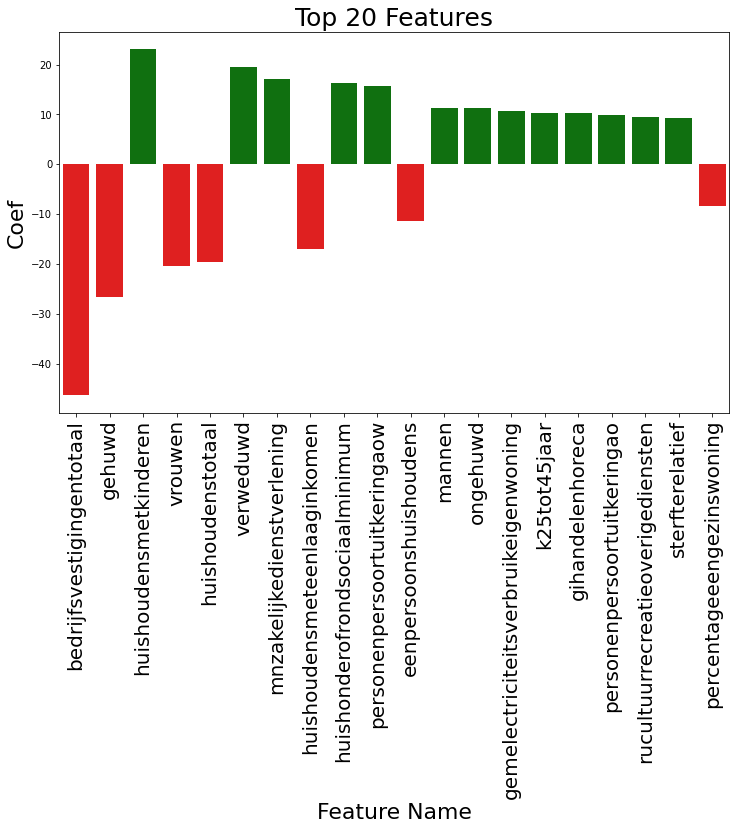

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import altair as alt

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [135]:
pl_lasso["columntransformer"].transformers_[0][1][1].get_feature_names()

array(['x0_Totaal', 'x0_Missing', "x1_'s-Gravenhage",
       "x1_'s-Hertogenbosch", 'x1_Aa en Hunze', 'x1_Aalburg',
       'x1_Aalsmeer', 'x1_Aalten', 'x1_Achtkarspelen', 'x1_Alblasserdam',
       'x1_Albrandswaard', 'x1_Alkmaar', 'x1_Almelo', 'x1_Almere',
       'x1_Alphen aan den Rijn', 'x1_Alphen-Chaam', 'x1_Altena',
       'x1_Ameland', 'x1_Amersfoort', 'x1_Amstelveen', 'x1_Amsterdam',
       'x1_Apeldoorn', 'x1_Arnhem', 'x1_Assen', 'x1_Asten',
       'x1_Baarle-Nassau', 'x1_Baarn', 'x1_Barendrecht', 'x1_Barneveld',
       'x1_Beek', 'x1_Beemster', 'x1_Beesel', 'x1_Bellingwedde',
       'x1_Berg en Dal', 'x1_Bergeijk', 'x1_Bergen (L.)',
       'x1_Bergen (NH.)', 'x1_Bergen op Zoom', 'x1_Berkelland',
       'x1_Bernheze', 'x1_Best', 'x1_Beuningen', 'x1_Beverwijk',
       'x1_Binnenmaas', 'x1_Bladel', 'x1_Blaricum', 'x1_Bloemendaal',
       'x1_Bodegraven-Reeuwijk', 'x1_Boekel', 'x1_Borger-Odoorn',
       'x1_Borne', 'x1_Borsele', 'x1_Boxtel', 'x1_Breda', 'x1_Brielle',
       'x1_Bro